In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import lib.dist as dist
import lib.utils as utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix', 
    'xtick.labelsize' : 13,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.labelsize' : 13, 
    'ytick.right' : True, 
    'axes.labelsize' : 16,
    'legend.frameon': False,
    'legend.fontsize': 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600,
    'savefig.bbox' : 'tight'
})
torch.__version__

'1.7.1'

# = 12, T = 2.42


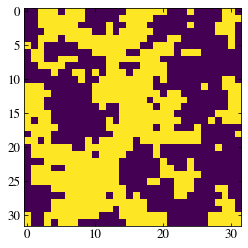

In [2]:
spin2d = np.arange(900*32*32)
spin2d = spin2d.reshape(900, 1, 32, 32)
for n in range (30):
    txt = np.loadtxt(f'isingspin/spin32_{n:02d}.txt')
    spin2d[30*n:30*(n+1)] = txt[:30, 2:].reshape(30, 1, 32, 32)

latent_dim = 8
beta = 4
prior_dist = dist.Normal()
q_dist = dist.Normal()

num = 372
plt.imshow(spin2d[num,0])
print('# = %d, T = %.2f'%(int(num/30), int(num/30)*0.2+0.02))

spin2d = torch.Tensor(spin2d)

In [3]:
output_dim = 16
input_dim = 8
conv1 = nn.Conv2d(1, 16, 4, 2, 1)  # 16
bn1 = nn.BatchNorm2d(16)
conv2 = nn.Conv2d(16, 16, 4, 2, 1)  # 8
bn2 = nn.BatchNorm2d(16)
conv3 = nn.Conv2d(16, 32, 4, 2, 1)  # 4
bn3 = nn.BatchNorm2d(32)
conv4 = nn.Conv2d(32, 256, 4)
bn4 = nn.BatchNorm2d(256)
conv_z = nn.Conv2d(256, output_dim, 1)
act = nn.SELU()

x = spin2d
h = x.view(-1, 1, 32, 32)
h = act(bn1(conv1(h)))
h = act(bn2(conv2(h)))
h = act(bn3(conv3(h)))
h = act(bn4(conv4(h)))
z = conv_z(h).view(spin2d.size(0), output_dim)
zp = z.view(x.size(0), 8, 2)
zs = model.q_dist.sample(params=zp)
print(z.shape, zp.shape, zs.shape)


conv1 = nn.ConvTranspose2d(input_dim, 256, 1, 1, 0)  # 1 x 1
bn1 = nn.BatchNorm2d(256)
conv2 = nn.ConvTranspose2d(256, 32, 4, 1, 0)  # 4
bn2 = nn.BatchNorm2d(32)
conv3 = nn.ConvTranspose2d(32, 16, 4, 2, 1)  # 8
bn3 = nn.BatchNorm2d(16)
conv4 = nn.ConvTranspose2d(16, 16, 4, 2, 1)  # 16
bn4 = nn.BatchNorm2d(16)
conv_final = nn.ConvTranspose2d(16, 1, 4, 2, 1) #32

h = z.view(z.size(0), z.size(1), 1, 1)
h = act(bn1(conv1(h)))
h = act(bn2(conv2(h)))
h = act(bn3(conv3(h)))
h = act(bn4(conv4(h)))
mu_img = conv_final(h)

NameError: name 'model' is not defined

In [4]:
class CEncoder(nn.Module):
    def __init__(self, output_dim):
        super(CEncoder, self).__init__()
        self.output_dim = output_dim

        self.conv1 = nn.Conv2d(1, 16, 4, 2, 1)  # 16
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 4, 2, 1)  # 8
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 4, 2, 1)  # 4
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 256, 4)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv_z = nn.Conv2d(256, output_dim, 1)

        # setup the non-linearity
        self.act = nn.SELU()

    def forward(self, x):
        h = x.view(-1, 1, 32, 32)
        h = self.act(self.bn1(self.conv1(h)))
        h = self.act(self.bn2(self.conv2(h)))
        h = self.act(self.bn3(self.conv3(h)))
        h = self.act(self.bn4(self.conv4(h)))
        z = self.conv_z(h).view(x.size(0), self.output_dim)
        return z
    
class CDecoder(nn.Module):
    def __init__(self, input_dim):
        super(CDecoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_dim, 256, 1, 1, 0)  # 1 x 1
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 32, 4, 1, 0)  # 4
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.ConvTranspose2d(32, 16, 4, 2, 1)  # 8
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.ConvTranspose2d(16, 16, 4, 2, 1)  # 16
        self.bn4 = nn.BatchNorm2d(16)
        self.conv_final = nn.ConvTranspose2d(16, 1, 4, 2, 1) #32

        # setup the non-linearity
        self.act = nn.SELU()

    def forward(self, z):
        h = z.view(z.size(0), z.size(1), 1, 1)
        h = self.act(self.bn1(self.conv1(h)))
        h = self.act(self.bn2(self.conv2(h)))
        h = self.act(self.bn3(self.conv3(h)))
        h = self.act(self.bn4(self.conv4(h)))
        mu_img = self.conv_final(h)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
def display_samples(model, x):
    fig, ax = plt.subplots(1,5, figsize = (15, 3))
    th = 11
    sample_mu = model.model_sample(batch_size=100).sigmoid()
    xs, x_params, zs, z_params = model.reconstruct_img(x)
    ax[0].imshow(x[th,0])
    ax[1].imshow(xs[th,0])
    ax[2].imshow(x_params[th,0].detach().numpy())
    ax[3].imshow(z_params[:,:,0].detach().numpy())
    ax[4].imshow(z_params[:,:,1].detach().numpy())
    plt.show()

In [5]:
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()
        
        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(self.z_dim, 2))

        self.encoder = CEncoder(z_dim * self.q_dist.nparams)
        self.decoder = CDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params
    
    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 1, 32, 32)
        z_params = self.encoder.forward(x).view(x.size(0), self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), 1, 32, 32)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params
    
    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()
    
    def elbo(self, x, dataset_size):
        batch_size = x.size(0) 
        x = x.view(batch_size, 1, 32, 32)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1) 

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, self.z_dim),
                                         z_params.view(1, batch_size, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(2), dim=1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz, dim=1, keepdim=False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()


In [7]:
model = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model.load_state_dict(torch.load('./frozen/VAE1.pth'))

<All keys matched successfully>

[n = 000] ELBO = 258.493134 (-378.209617)


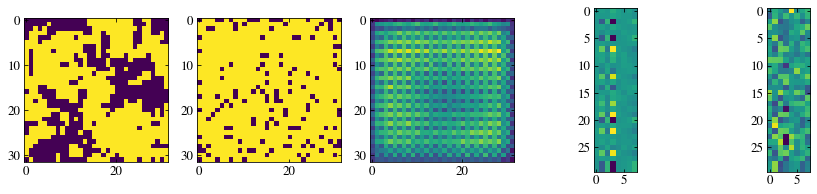

[n = 050] ELBO = 3660.086426 (3687.099045)


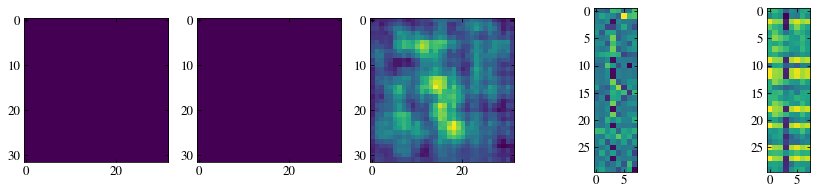

[n = 100] ELBO = 4317.089355 (3784.076102)


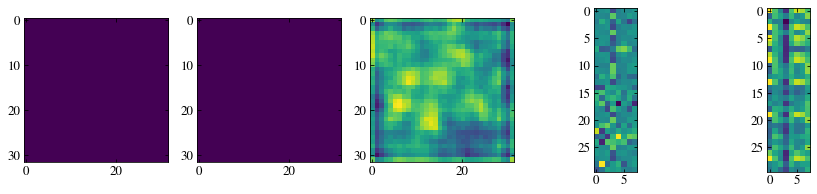

[n = 150] ELBO = 3604.559326 (3976.555348)


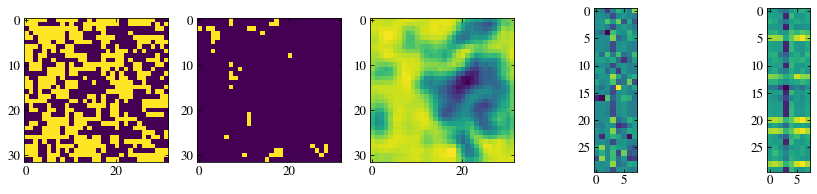

[n = 200] ELBO = 4465.410645 (4119.194962)


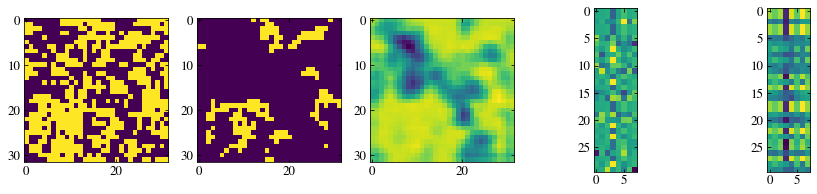

[n = 250] ELBO = 6070.927734 (4240.580319)


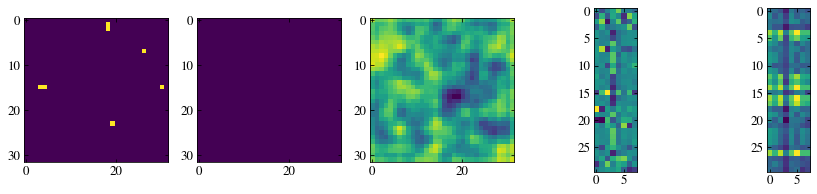

[n = 300] ELBO = 5012.184082 (4393.634222)


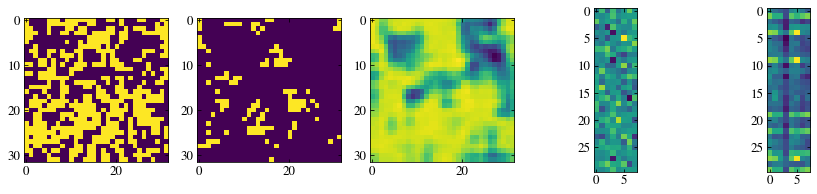

[n = 350] ELBO = 4960.270020 (4441.943187)


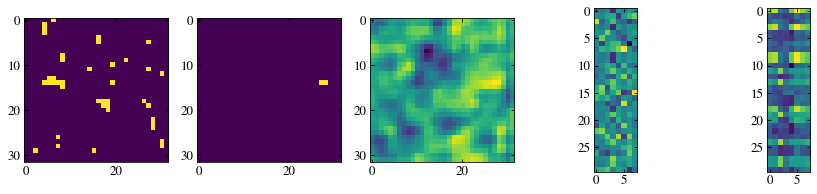

[n = 400] ELBO = 4066.366943 (4530.919748)


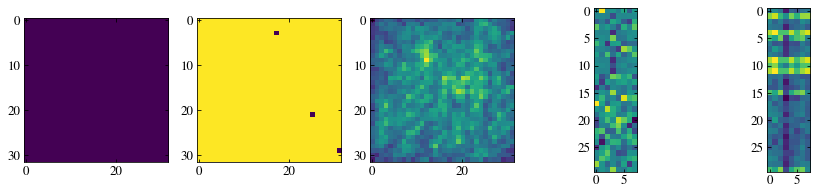

[n = 450] ELBO = 4701.976074 (4473.804166)


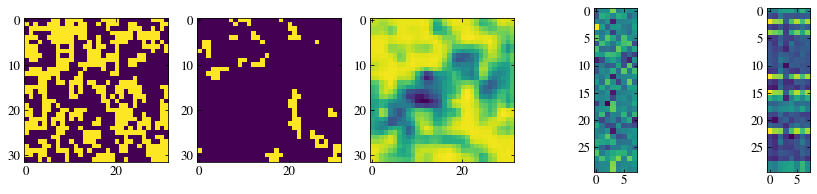

[n = 500] ELBO = 2954.278809 (4513.459938)


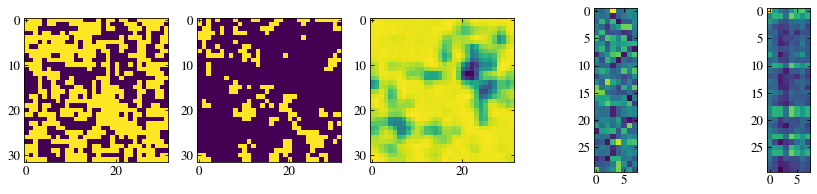

[n = 550] ELBO = 3987.738281 (4589.824259)


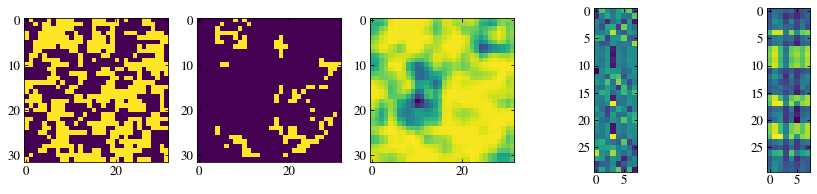

[n = 600] ELBO = 5289.171387 (4733.499479)


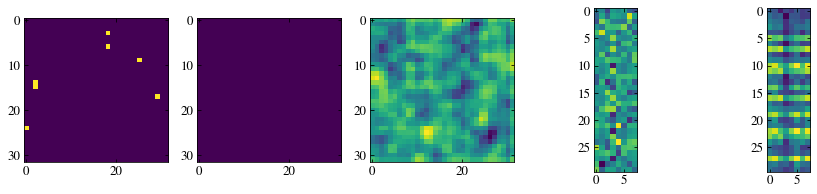

[n = 650] ELBO = 4900.749023 (4700.440241)


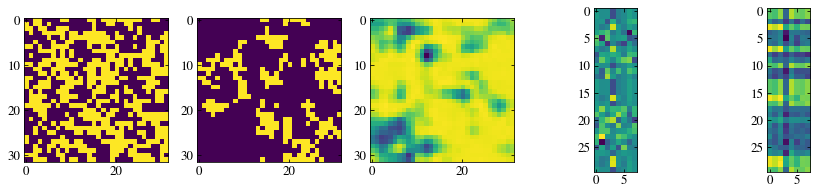

[n = 700] ELBO = 5431.447754 (4717.909323)


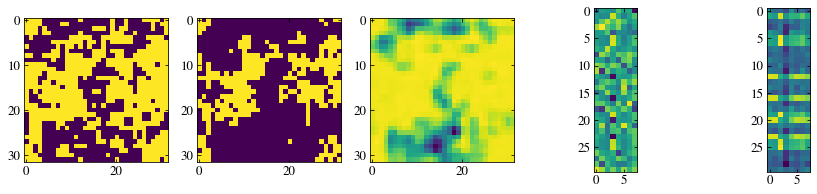

[n = 750] ELBO = 4180.619629 (4825.642798)


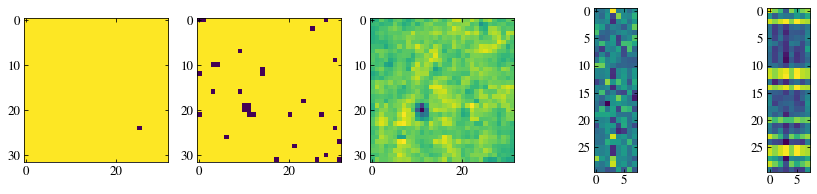

[n = 800] ELBO = 5208.647461 (4869.176522)


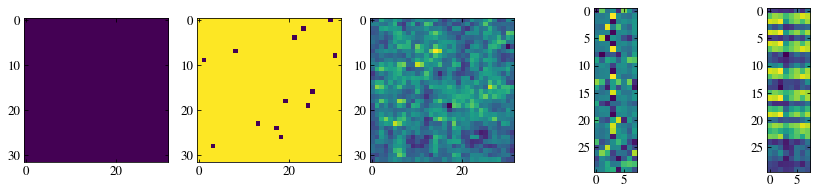

[n = 850] ELBO = 5765.474121 (4901.693771)


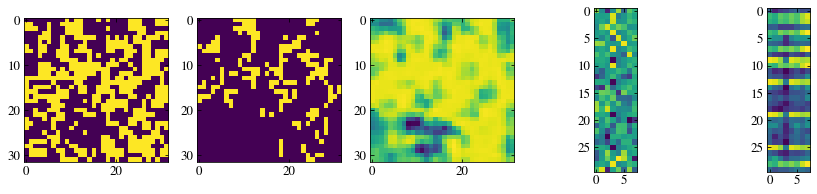

[n = 900] ELBO = 3327.270264 (4822.306404)


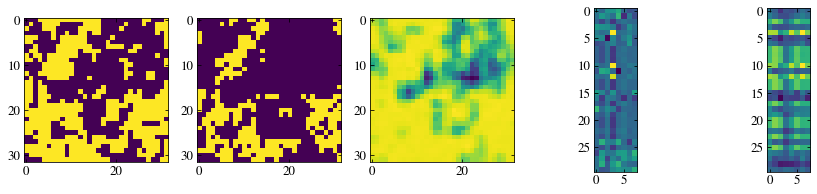

[n = 950] ELBO = 4011.521729 (4900.861774)


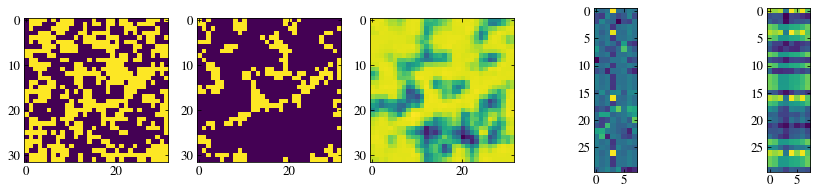

[n = 1000] ELBO = 2659.232910 (4892.430706)


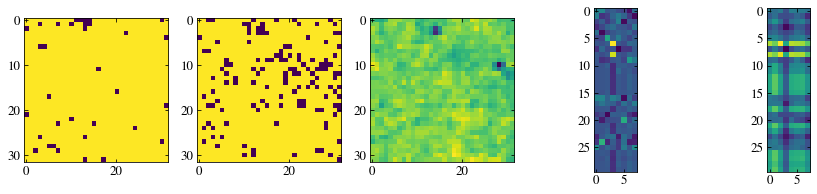

[n = 1050] ELBO = 4879.564941 (5028.300120)


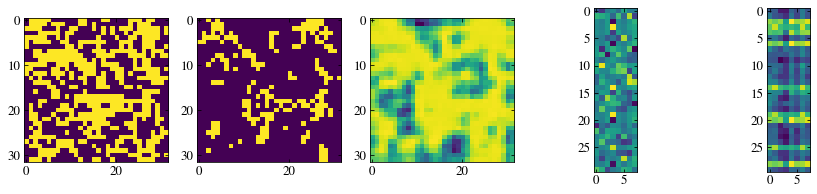

[n = 1100] ELBO = 6613.202148 (4941.390959)


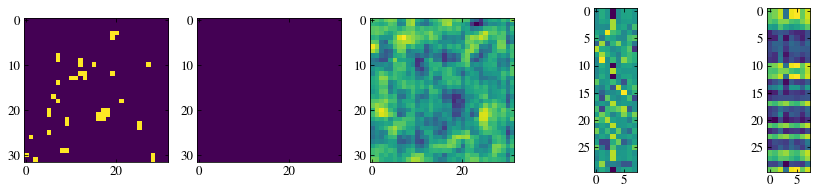

[n = 1150] ELBO = 5533.266113 (5010.474056)


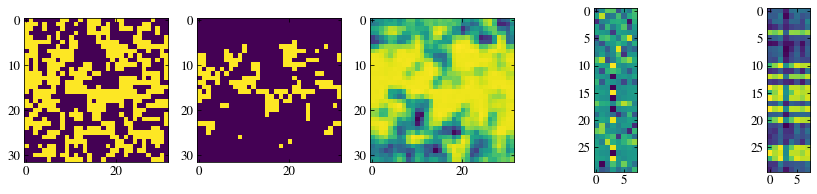

[n = 1200] ELBO = 5656.884277 (5065.761027)


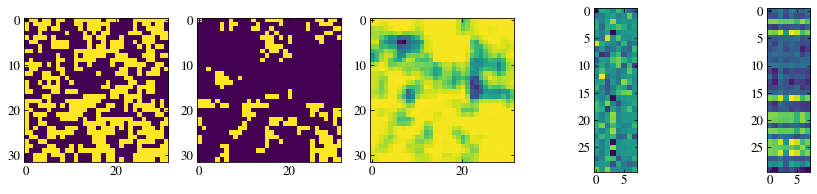

[n = 1250] ELBO = 3987.284424 (4993.548725)


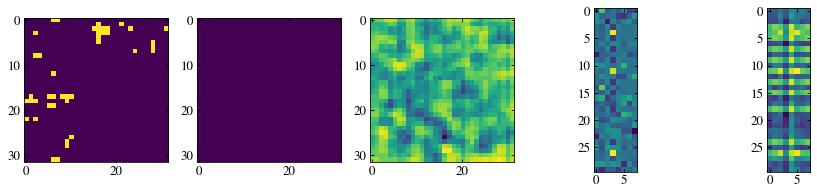

[n = 1300] ELBO = 4656.206543 (5022.759515)


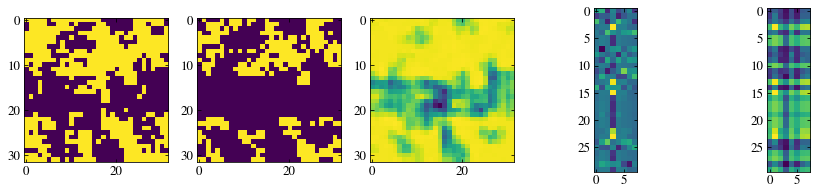

[n = 1350] ELBO = 6196.645020 (5065.795318)


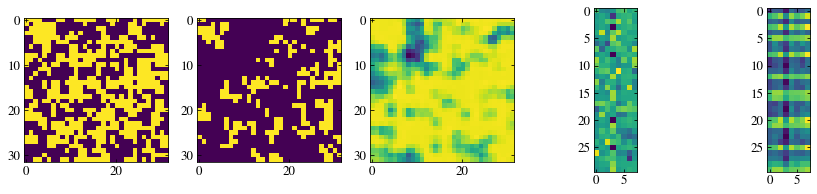

[n = 1400] ELBO = 5728.007324 (5057.910175)


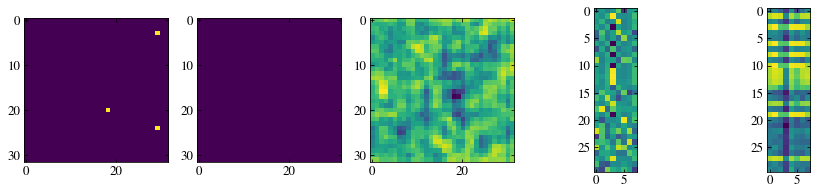

[n = 1450] ELBO = 5528.819824 (5141.818923)


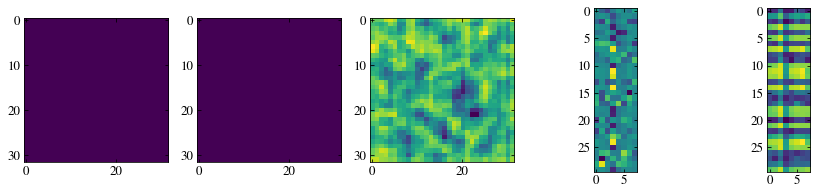

[n = 1500] ELBO = 3161.189697 (5080.421331)


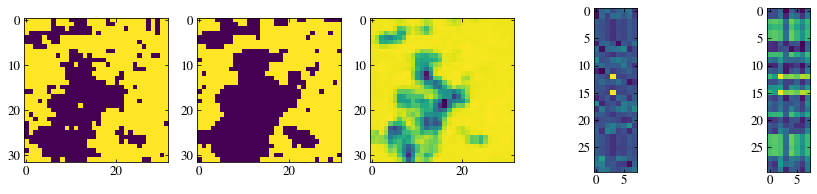

[n = 1550] ELBO = 4847.092773 (5134.812513)


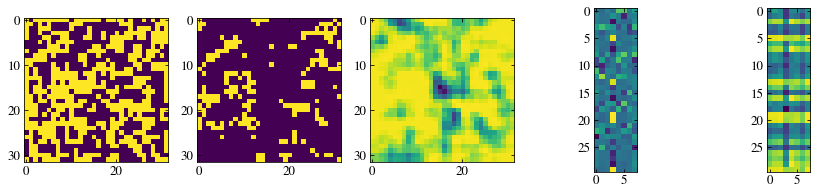

[n = 1600] ELBO = 3127.829102 (5071.226862)


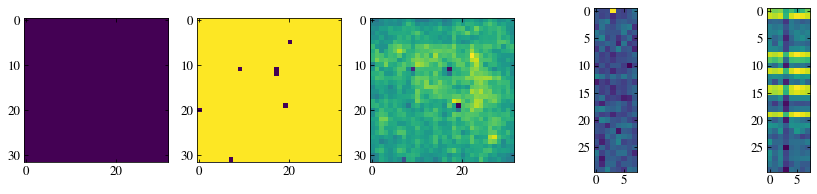

[n = 1650] ELBO = 4189.496582 (5115.438727)


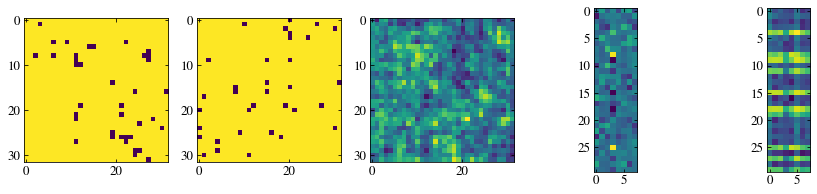

[n = 1700] ELBO = 4462.578125 (5125.330690)


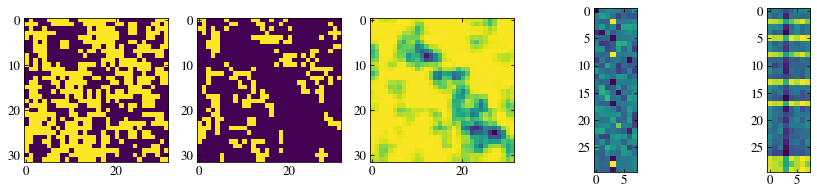

[n = 1750] ELBO = 5133.895020 (5122.621440)


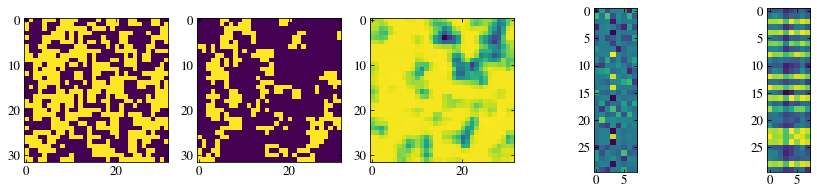

[n = 1800] ELBO = 4093.296631 (5207.102914)


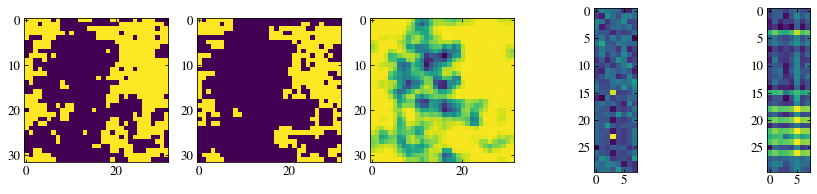

[n = 1850] ELBO = 5458.049316 (5212.413624)


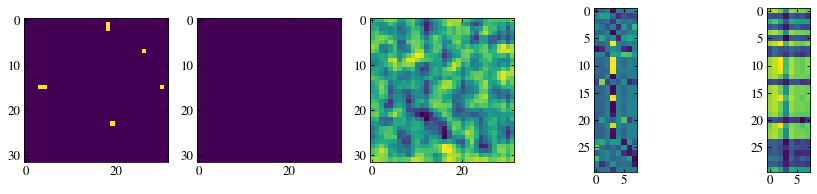

[n = 1900] ELBO = 4573.857910 (5238.346172)


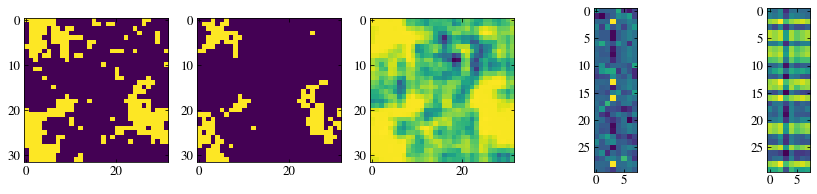

[n = 1950] ELBO = 4741.258301 (5237.906192)


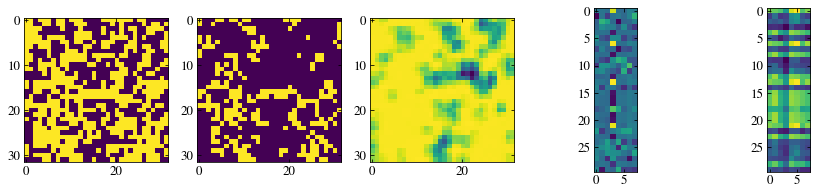

[n = 2000] ELBO = 4848.682617 (5238.338625)


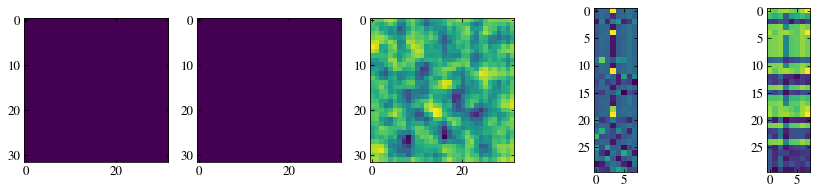

[n = 2050] ELBO = 4987.273926 (5222.115571)


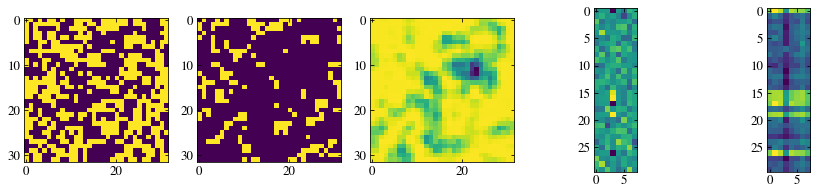

[n = 2100] ELBO = 4349.569824 (5247.507892)


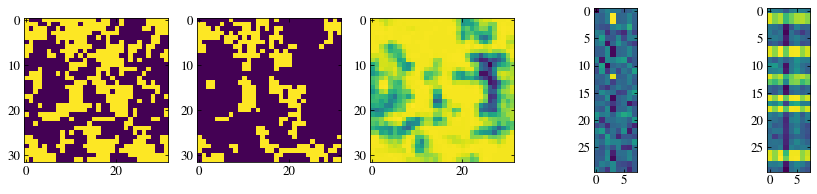

[n = 2150] ELBO = 5061.153320 (5244.960213)


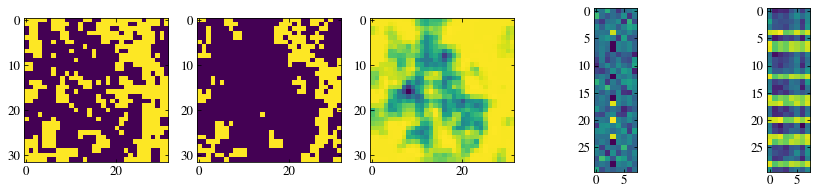

[n = 2200] ELBO = 4663.940430 (5283.162362)


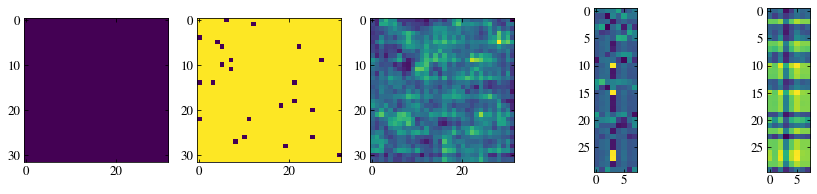

[n = 2250] ELBO = 5775.261230 (5218.202648)


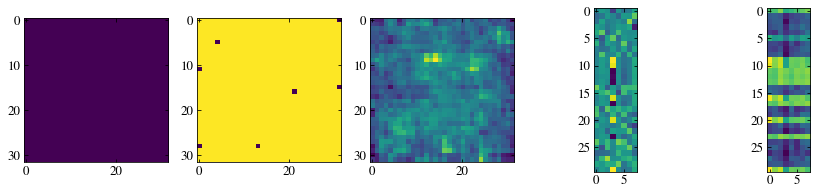

[n = 2300] ELBO = 3865.890625 (5264.851546)


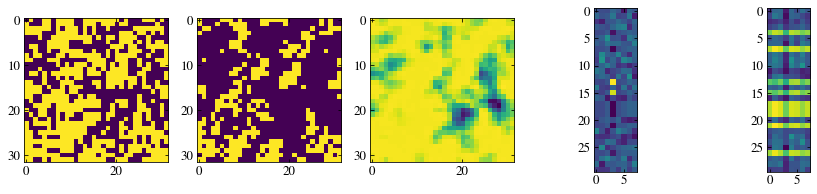

[n = 2350] ELBO = 5412.358398 (5312.397901)


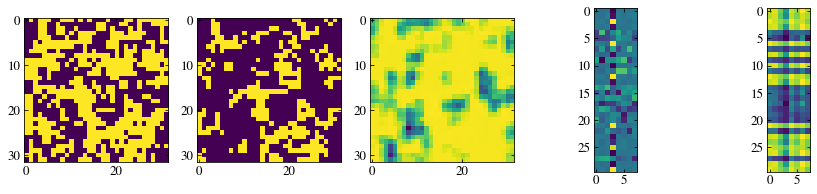

[n = 2400] ELBO = 6202.063477 (5342.518657)


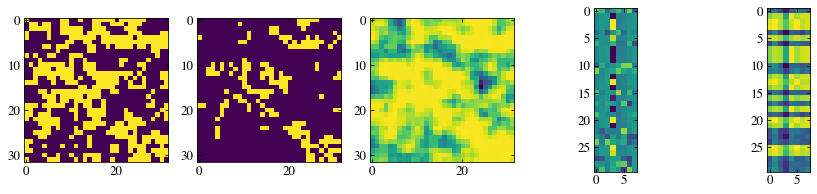

[n = 2450] ELBO = 4960.953613 (5366.012517)


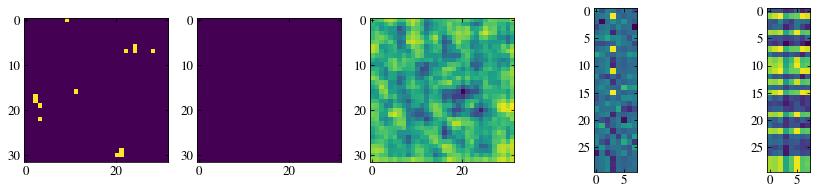

[n = 2500] ELBO = 4293.254395 (5300.117181)


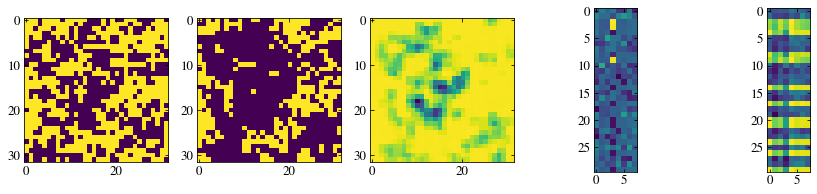

[n = 2550] ELBO = 4899.768066 (5373.732690)


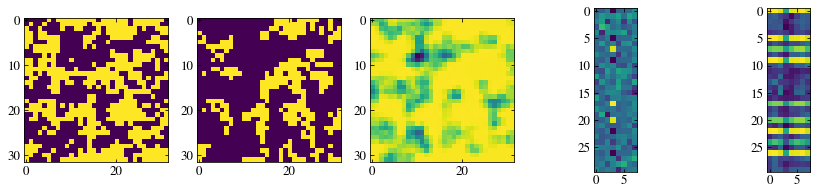

[n = 2600] ELBO = 5673.100586 (5294.921397)


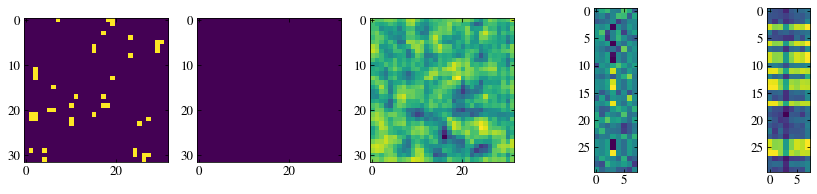

[n = 2650] ELBO = 3018.408447 (5296.185974)


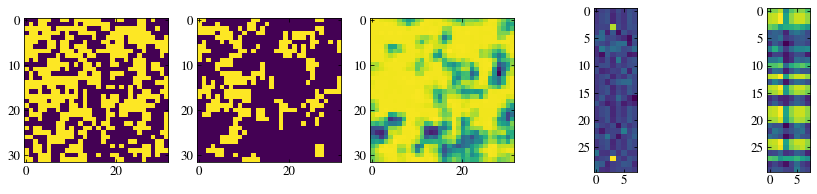

[n = 2700] ELBO = 5197.681152 (5404.323026)


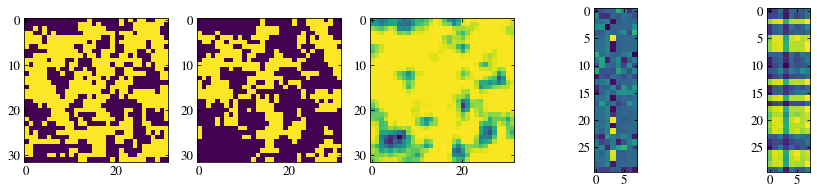

[n = 2750] ELBO = 4795.483398 (5326.770570)


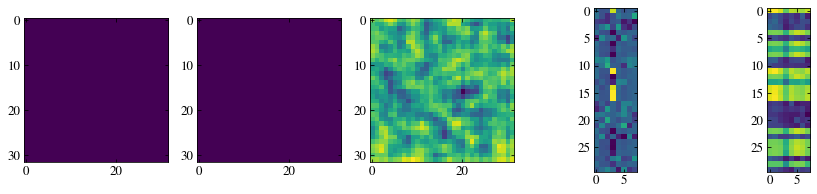

[n = 2800] ELBO = 5703.893066 (5314.302735)


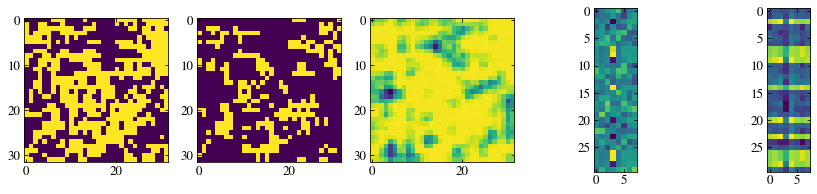

[n = 2850] ELBO = 5424.281738 (5385.564764)


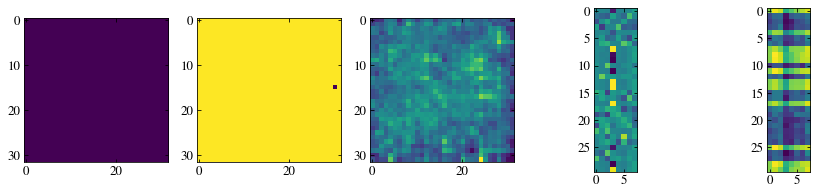

[n = 2900] ELBO = 5146.758789 (5382.579778)


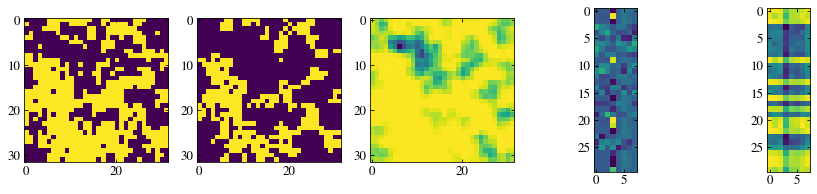

[n = 2950] ELBO = 5651.556641 (5379.250544)


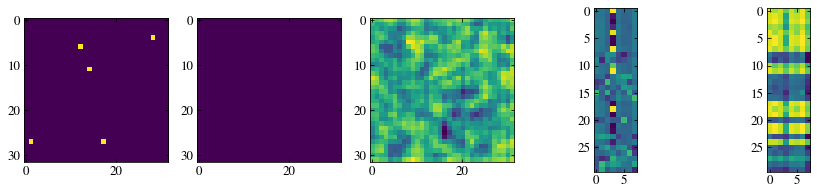

In [235]:
model = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loader=DataLoader(dataset=spin2d, batch_size=30, shuffle=True)

train_elbo = []
dataset_size = len(train_loader.dataset)
num_iter = len(train_loader)*100
elbo_run_mean = utils.RunningAverageMeter()

for n in range(num_iter):
    for i,x in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        obj, elbo = model.elbo(x, dataset_size)
        if utils.isnan(obj).any(): break
        obj.mean().mul(-1).backward()
        elbo_run_mean.update(elbo.mean().item())
        optimizer.step()
        
    if n%50==0:
        train_elbo.append(elbo_run_mean.avg)
        print('[n = %03d] ELBO = %.6f (%.6f)'%(n, elbo_run_mean.val, elbo_run_mean.avg))
        display_samples(model, x)

In [8]:
spin2dtest = np.arange(200*30*32*32)
spin2dtest = spin2dtest.reshape(200*30, 1, 32, 32)
for n in range (30):
    txt = np.loadtxt(f'isingspin/spin32_{n:02d}.txt')
    spin2dtest[200*n:200*(n+1)] = txt[:, 2:].reshape(200, 1, 32, 32)

spin2dtest = torch.Tensor(spin2dtest)

In [10]:
xs, x_params, zs, z_params = model.reconstruct_img(spin2dtest)

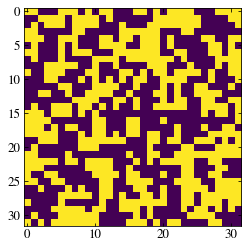

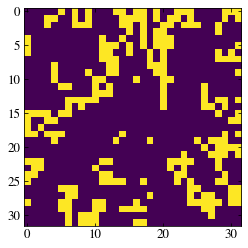

In [18]:
n = np.random.randint(200*30)
plt.imshow(spin2dtest[n].reshape(32,32))
plt.show()
plt.imshow(xs[n].reshape(32,32))

In [22]:
xs.min()

tensor(0.)

In [9]:
test_mu = z_params[:, :, 0].detach().numpy()
test_logsig = z_params[:, :, 1].detach().numpy()
test_var = np.exp(test_logsig * 2)
fig, ax = plt.subplots(1,2, figsize = (6, 6))
ax[0].imshow(test_mu, aspect = 16/3000)
ax[1].imshow(test_var, aspect = 16/3000)

NameError: name 'z_params' is not defined

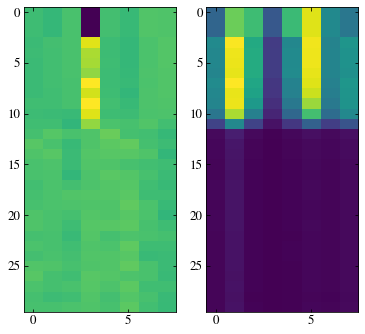

In [303]:
test_ens_mu = np.zeros((30, 8))
test_ens_logsig = np.zeros((30, 8))
for i in range(30):
    test_ens_mu[i] = np.average(z_params[i*200:(i+1)*200, :, 0].detach().numpy(), axis=0)
    test_ens_logsig[i] = np.average(z_params[i*200:(i+1)*200, :, 1].detach().numpy(), axis=0)
test_ens_var = np.exp(test_ens_logsig * 2)
fig, ax = plt.subplots(1,2, figsize = (6, 6))
ax[0].imshow(test_ens_mu, aspect = 16/30)
ax[1].imshow(test_ens_var, aspect = 16/30)

In [259]:
torch.save(model.state_dict(), 'frozen/VAE1.pth')

# PCA

In [256]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [329]:
pca2.explained_variance_

array([8.97965419e-04, 1.74442410e-05, 5.30592151e-07])

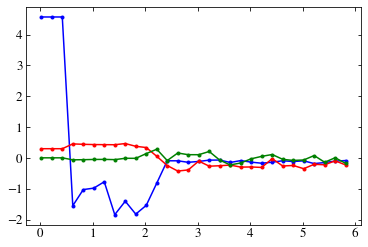

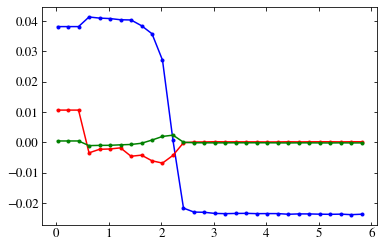

In [328]:
#scaler1 = StandardScaler()
#scaler1.fit(test_mu)
#mu_scaled = scaler1.transform(test_mu)
pca1 = PCA(n_components=3)
pca1.fit(test_ens_mu)
mu_pca = pca1.transform(test_ens_mu)

#scaler2 = StandardScaler()
#scaler2.fit(test_var)
#var_scaled = scaler2.transform(test_var)
pca2 = PCA(n_components=3)
pca2.fit(test_ens_var)
var_pca = pca2.transform(test_ens_var)

T = np.arange(30)*0.2+0.02
TT = np.repeat(T, 1)

plt.plot(TT, mu_pca[:,0], 'b.-')
plt.plot(TT, mu_pca[:,1], 'r.-')
plt.plot(TT, mu_pca[:,2], 'g.-')
plt.show()

plt.plot(TT, var_pca[:,0], 'b.-')
plt.plot(TT, var_pca[:,1], 'r.-')
plt.plot(TT, var_pca[:,2], 'g.-')
plt.show()

In [60]:
"""### VAE
cCh=16
ksize=7
fD=cCh*2*20*20
zD=16
class VAE(nn.Module):
    def __init__(self, imgCh=1): # 7: 32-26-20, 5: 32-28-24
        super().__init__()
    
        self.eC1 = nn.Conv2d(imgCh, cCh, kernel_size = ksize)
        self.eC2 = nn.Conv2d(cCh, cCh*2, kernel_size = ksize)
        self.eL1 = nn.Linear(fD, zD) 
        self.eL2 = nn.Linear(fD, zD)
    
        self.dL1 = nn.Linear(zD, fD)
        self.dC1 = nn.ConvTranspose2d(cCh*2, cCh, ksize)
        self.dC2 = nn.ConvTranspose2d(cCh, imgCh, ksize)
    
        self.actv = nn.SELU()
        self.Sigm = torch.Sigmoid()
    
    def encoder(self, x):
        x = self.actv(self.eC1(x))
        x = self.actv(self.eC2(x))
        x = x.view(-1, fD)
        mu = self.eL1(x)
        logvar = self.eL2(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        x = self.actv(self.dL1(z))
        x = x.view(-1, cCh*2, 20, 20)
        x = self.actv(self.dC1(x))
        x = self.Sigm(self.dC2(x))
        return x
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return out, mu, logvar"""